# Data transformation and outlier detection

Gensor provides some simple ways to find and eliminate outliers from the data. It can also be used in combination, for example we can first transform the data and then remove outliers, what can be an effective strategy in some cases. Below we quickly get the dataset created in the previous tutorial.

Loading file: /workspaces/gensor/gensor/testdata/Barodiver_220427183008_BY222.csv
Loading file: /workspaces/gensor/gensor/testdata/PB02A_plain.csv
Skipping file /workspaces/gensor/gensor/testdata/PB02A_plain.csv due to missing metadata.
Loading file: /workspaces/gensor/gensor/testdata/PB01A_moni_AV319_220427183019_AV319.csv
Loading file: /workspaces/gensor/gensor/testdata/PB02A_plain.csv


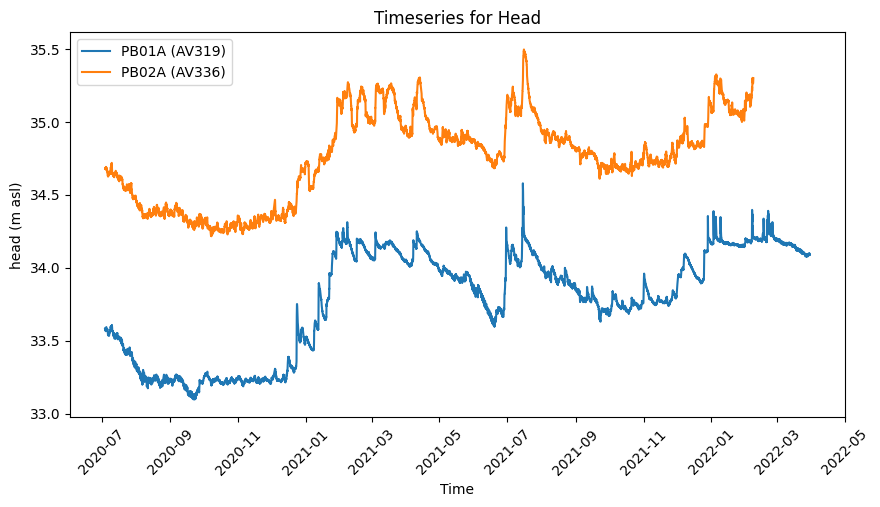

In [3]:
import gensor as gs
from gensor.testdata import all_paths, pb02a_plain

from gensor import read_from_csv

pattern = r'[A-Za-z]{2}\d{2}[A-Za-z]{1}|Barodiver'

ds = read_from_csv(path=all_paths, 
                    file_format='vanessen', 
                    location_pattern=pattern)

ds2 = read_from_csv(path=pb02a_plain, 
                    file_format='plain', 
                    location='PB02A',
                    sensor='AV336')

ds.add(ds2)

baro = ds.filter(stations='Barodiver', variables='pressure')
alts = {
    "PB01A": 31.48,
    "PB02A": 31.68
    }

groundwater_ds = ds.filter(stations=alts.keys(), variables="pressure")

for ts in groundwater_ds:
    ts.sensor_alt = alts.get(ts.location)
    
fieldwork_days = {"PB01A": ['2020-08-25', '2020-10-20', '2020-11-18', '2020-12-03', '2020-12-08',
                  '2021-02-17', '2021-03-10', '2021-04-14', '2021-05-18', '2021-05-27',
                  '2021-08-17', '2021-09-16'],
                  "PB02A": ['2020-08-25', '2020-10-20', '2020-11-18', '2020-12-03', '2020-12-08',
                  '2021-02-17', '2021-03-10', '2021-04-14', '2021-05-18', '2021-05-27',
                  '2021-08-17', '2021-09-16', '2021-04-26']}

compensated_ds = gs.compensate(groundwater_ds, baro, fieldwork_dates=fieldwork_days, interpolate_method='linear')
compensated_ds.plot()

In the graph above we see that even after compensation and dropping some measurements due to a low water column* there are still some obvious outliers. We can use outlier detection coupled with transformation to detect these outliers and remove them from the dataset.

*these are the records taken by the sensor when it was out of the water and measured atmospheric pressure.

In [4]:
ts = compensated_ds[1].model_copy()


In [5]:
from numpy import median

def mad(s):
    med = median(s)
    return median(abs(s - med))

ts.rolling(6).apply(lambda s: mad(s))


timestamp
2020-07-04 06:00:00+00:00         NaN
2020-07-04 07:00:00+00:00         NaN
2020-07-04 08:00:00+00:00         NaN
2020-07-04 09:00:00+00:00         NaN
2020-07-04 10:00:00+00:00         NaN
                               ...   
2022-02-07 12:00:00+00:00    0.002205
2022-02-07 13:00:00+00:00    0.002205
2022-02-07 14:00:00+00:00    0.002205
2022-02-07 15:00:00+00:00    0.005500
2022-02-07 16:00:00+00:00    0.011580
Freq: h, Name: pressure, Length: 14003, dtype: float64

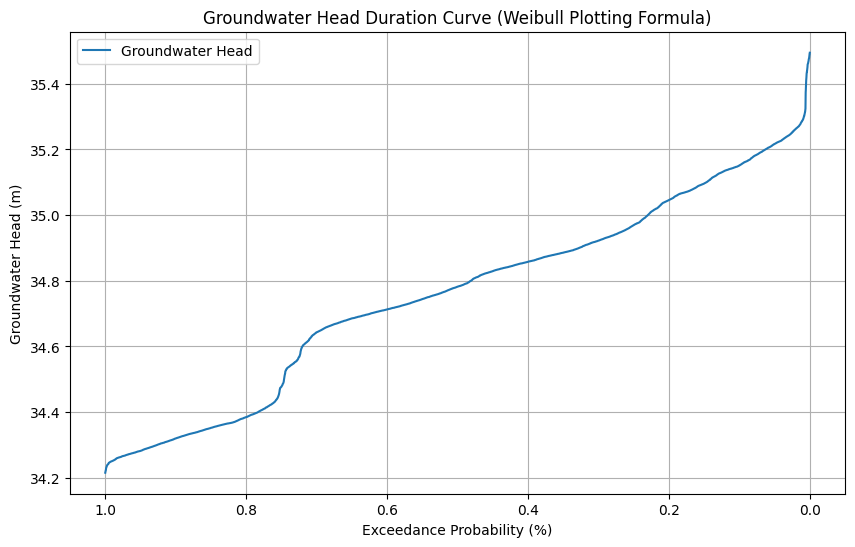

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def groundwater_head_weibull_curve(groundwater_data: pd.Series) -> None:
    """
    Derives and plots the groundwater head duration curve using the Weibull plotting formula.
    
    Parameters:
        groundwater_data (pd.Series): The time series of groundwater head data.
    """
    # Convert to numeric and drop non-numeric and NaN values
    groundwater_data = groundwater_data.apply(pd.to_numeric, errors='coerce')
    groundwater_data = groundwater_data.dropna()  # Drop NaN values
    
    # Sort the data in descending order
    sorted_data = groundwater_data.sort_values(ascending=False)
    
    # Total number of data points
    n = len(sorted_data)
    
    # Weibull plotting formula for exceedance probability: P = m / (n + 1)
    ranks = range(1, n + 1)
    exceedance_probability = [(m / (n + 1)) for m in ranks]
    
    # Plot the Weibull-based duration curve
    plt.figure(figsize=(10, 6))
    plt.plot(exceedance_probability, sorted_data, label='Groundwater Head')
    
    plt.xlabel('Exceedance Probability (%)')
    plt.ylabel('Groundwater Head (m)')
    plt.title('Groundwater Head Duration Curve (Weibull Plotting Formula)')
    
    # Convert exceedance probability to percentage
    plt.gca().invert_xaxis()  # Invert the x-axis to show decreasing probability
    plt.grid(True)
    plt.legend()
    
    plt.show()

# Example: Assuming `ts.ts` is your pandas Series of groundwater head data
groundwater_head_weibull_curve(ts.ts)


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

import pandas as pd
from scipy.stats import skew
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import numpy as np

Skewness: -0.12095906676647102


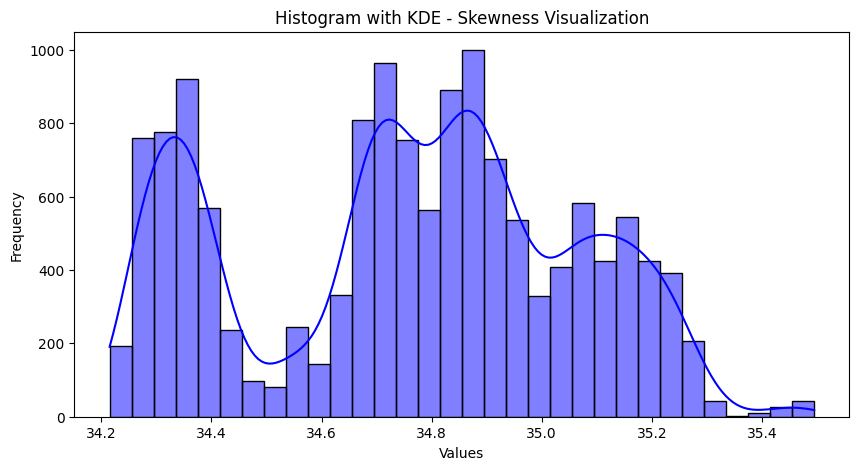

In [8]:
# 1. Skewness
skewness = skew(ts)
print(f"Skewness: {skewness}")


plt.figure(figsize=(10, 5))
sns.histplot(ts.ts, kde=True, color='blue')
plt.title('Histogram with KDE - Skewness Visualization')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

Skewness: 0.6096825482626816


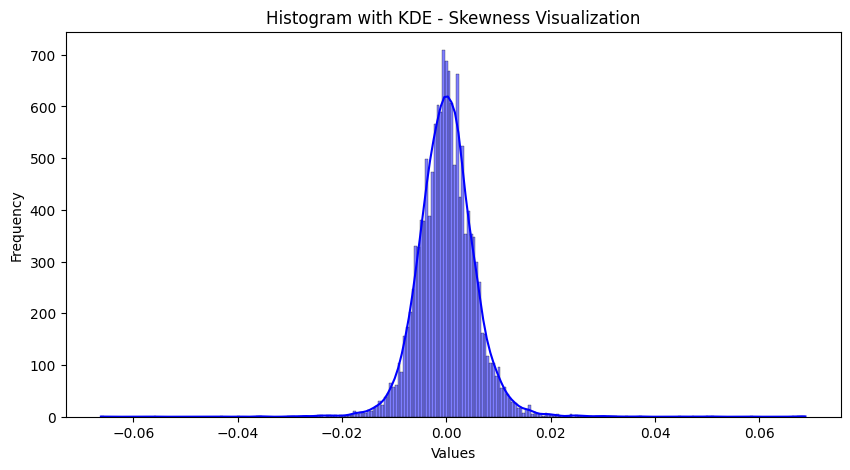

In [9]:
trans_ts = ts.transform('difference')
skewness = skew(trans_ts.ts)
print(f"Skewness: {skewness}")


plt.figure(figsize=(10, 5))
sns.histplot(trans_ts.ts, kde=True, color='blue')
plt.title('Histogram with KDE - Skewness Visualization')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

Residuals from linear model: timestamp
2020-07-04 06:00:00+00:00    0.238780
2020-07-04 07:00:00+00:00    0.243575
2020-07-04 08:00:00+00:00    0.241190
2020-07-04 09:00:00+00:00    0.238145
2020-07-04 10:00:00+00:00    0.243939
                               ...   
2022-02-07 12:00:00+00:00    0.190861
2022-02-07 13:00:00+00:00    0.199225
2022-02-07 14:00:00+00:00    0.209350
2022-02-07 15:00:00+00:00    0.213885
2022-02-07 16:00:00+00:00    0.222839
Freq: h, Length: 14003, dtype: float64


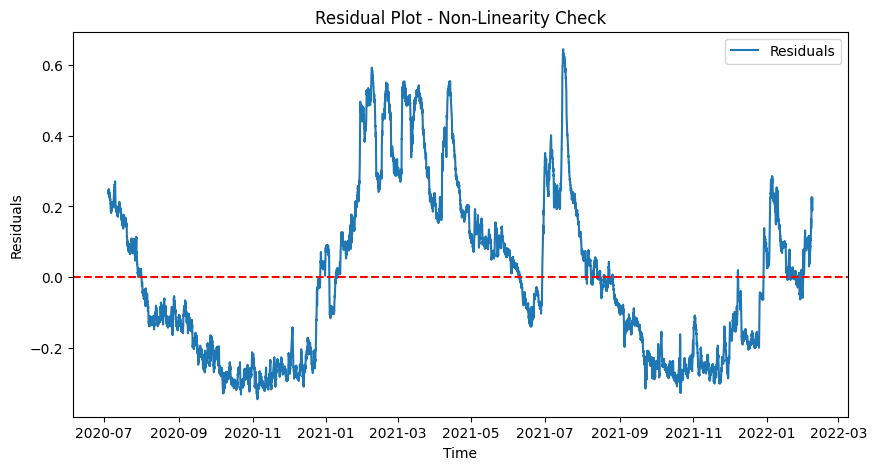

In [10]:
# 2. Non-linearity (Linear regression and residuals)
time_index = np.arange(len(ts.ts))
X = sm.add_constant(time_index)
model = sm.OLS(ts.ts, X)
results = model.fit()
residuals = results.resid
print(f"Residuals from linear model: {residuals}")

# Residuals from linear regression
plt.figure(figsize=(10, 5))
plt.plot(ts.ts.index, residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot - Non-Linearity Check')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

Seasonal Component: [ 0.00013635 -0.00173199 -0.00328756 ...  0.00330321  0.00335359
  0.0029846 ]
Trend Component: [nan nan nan ... nan nan nan]


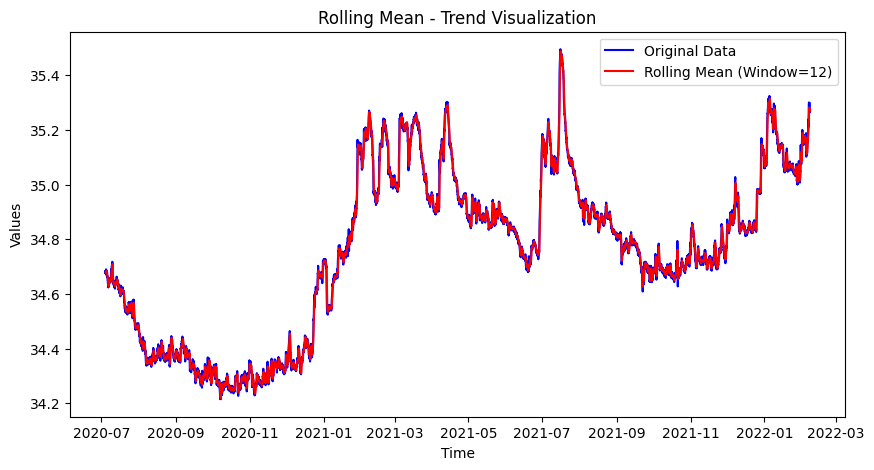

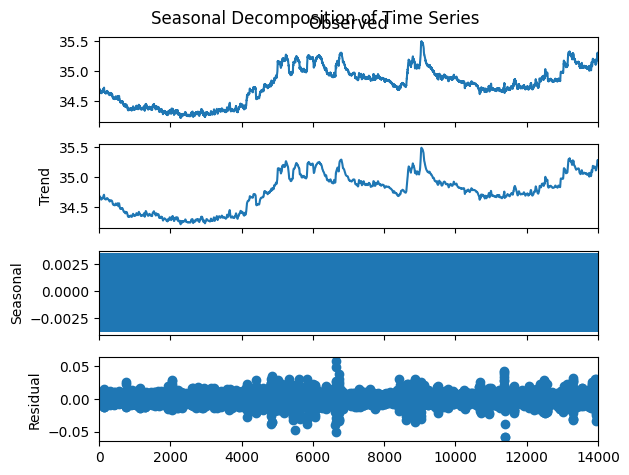

In [11]:
# 3. Seasonality and Trend (Decomposition)
decomposition = seasonal_decompose(ts, model='additive', period=12)
seasonality = decomposition.seasonal
trend = decomposition.trend
print(f"Seasonal Component: {seasonality}")
print(f"Trend Component: {trend}")

rolling_mean = ts.ts.rolling(window=12).mean()

plt.figure(figsize=(10, 5))
plt.plot(ts.ts.index, ts.ts, label='Original Data', color='blue')
plt.plot(ts.ts.index, rolling_mean, label='Rolling Mean (Window=12)', color='red')
plt.title('Rolling Mean - Trend Visualization')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

decomposition.plot()
plt.suptitle('Seasonal Decomposition of Time Series')
plt.show()

ADF Statistic: -1.4187030211880416
p-value: 0.5732775407266918


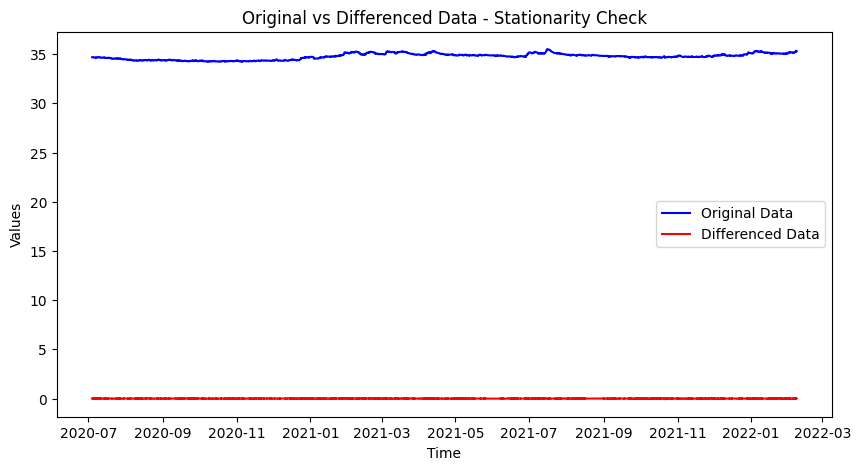

In [12]:
# 4. Stationarity (ADF Test)
adf_test = adfuller(ts)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

diff_ts = ts.ts.diff().dropna()

plt.figure(figsize=(10, 5))
plt.plot(ts.ts.index, ts.ts, label='Original Data', color='blue')
plt.plot(diff_ts.index, diff_ts, label='Differenced Data', color='red')
plt.title('Original vs Differenced Data - Stationarity Check')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()